In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import unidecode
from difflib import SequenceMatcher
import os
import matplotlib.lines as lines
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from PIL import Image,ImageOps
from highlight_text import fig_text

In [2]:
df = pd.read_csv('Data/results.csv')[['Date','Time','HomeTeam','AwayTeam','FTHG','FTAG']]
df.columns = ['Date','Time','Home','Away','Home Goals','Away Goals']
# df['Date'] = pd.to_datetime(df['Date'] + ' ' + df['Time']).dt.date
df['Date'] = pd.to_datetime(df['Date'],format='%d/%m/%Y').dt.date
df.drop('Time',axis=1,inplace=True)
df= df.replace({'Man ':'Manchester ','Wolves':'Wolverhampton Wanderers'},regex=True)
team_names = df['Home'].unique().tolist()

In [3]:
def create_table(df,team_names,date):
    def get_points(df):
        points = []
        for i,row in df.iterrows():
            if row['Played'] == 0:
                points.append(0)
            elif row['Scored'] > row['Conceded']:
                points.append(3)
            elif row['Scored'] < row['Conceded']:
                points.append(0)
            elif row['Scored'] == row['Conceded']:
                points.append(1)
            else:
                return -1
        return points
    
    date = pd.to_datetime(date).date()
    df = df[df['Date'] <= date]
    final = pd.DataFrame()
    for team in team_names:
        one = df[df['Home'] == team]
        if len(one) == 0:
            one = pd.DataFrame([team,'placeholder',np.NaN,np.NaN,0]).T
            one.columns = ['Team','Team2','Home Goals','Away Goals','Played']
        else:
            one['Played'] = 1
        home = pd.DataFrame()
        home['Scored'] = one['Home Goals']
        home['Conceded'] = one['Away Goals']
        home['Team'] = team
        home['Played'] = one['Played']
        home['Points'] = get_points(home)
        one = df[df['Away'] == team]
        if len(one) == 0:
            one = pd.DataFrame([team,'placeholder',np.NaN,np.NaN,0]).T
            one.columns = ['Team','Team2','Home Goals','Away Goals','Played']
        else:
            one['Played'] = 1
        away = pd.DataFrame()
        away['Scored'] = one['Away Goals']
        away['Conceded'] = one['Home Goals']
        away['Team'] = team
        away['Played'] = one['Played']
        away['Points'] = get_points(away)
        final = pd.concat([final,home,away])
    final = final.apply(pd.to_numeric, errors='ignore')
    table = final.groupby('Team').sum()[['Scored','Conceded','Points']]
    table['GD'] = table['Scored'] - table['Conceded']
    table['MP'] = final[final['Played'] == 1].groupby('Team').size()
    table.columns = ['GF','GA','P','GD','MP']
    table = table[['MP','GF','GA','GD','P']]
    table = table.sort_values(['P','GD','GF','GA','Team'],ascending=[False,False,False,False,True]).reset_index()
    table.index = table.index+1
    return table

In [4]:
def get_logo(clubs):
    logo_urls = []
    images = []
    for file in os.listdir(r"Teams\\"):
        images.append(file.replace('.png',''))
    def similar(a,b):
        return SequenceMatcher(None,a,b).ratio()
    similar_dict= dict() 
    for tochange in team_names:
        most = (0,0)
        for im in images:
            if (unidecode.unidecode(tochange) in unidecode.unidecode(im)) or (unidecode.unidecode(im) in unidecode.unidecode(tochange)):
                most = (1,im)
                break
            tmp = similar(tochange,im)
            if tmp < 0.70:
                continue
            elif tmp > most[0] and im not in similar_dict.values():
                most = (tmp,im)
        similar_dict[tochange] = most[1]
    for club in clubs:
        #name = club.replace('FC','')
        name = unidecode.unidecode(club)
        first = name.split()[0] 
        if os.path.exists(rf'\Teams\{name}.png'):
            name = r'Teams\\' + name + '.png'
            logo_urls.append(name)
        elif os.path.exists(rf'C{first}.png'):
            name = r'Teams\\' + first + '.png'
            logo_urls.append(name)
        else: 
            club = similar_dict.get(club)
            name = r'Teams\\' + club +'.png'
            logo_urls.append(name)
        #check
    for url in logo_urls:
        if not os.path.exists(url):
            print('Error:',url)
    return logo_urls

In [5]:
dates = df["Date"].unique().tolist()
dates = [i-timedelta(1) for i in dates] + dates 
dates = list(set(dates))
dates.sort()
latest = create_table(df,team_names,datetime.today())
team_names = latest['Team'].tolist() #sorted

In [6]:
final = dict()
for team in team_names:#intialise
    final[team] = [0]*20
start = dates[0]
for date in dates:
    days = (date-start).days
    table = create_table(df,team_names,date)
    pos_dict = table['Team'].to_dict()
    pos_dict = {v:k for k,v in pos_dict.items()}
    for team in team_names:
        position = pos_dict.get(team)
        lst = final.get(team)
        lst[position-1] += days
        final[team] = lst
    start = date #reset interval
vals = np.array([v for k,v in final.items()])

In [9]:
def plot_heatmap(ax,vals,font,cmap,text_color,axis_color):
    ax.imshow(vals,interpolation='nearest',extent=(0.5,20.5,20,0),cmap=cmap,vmin=7)
    logos = get_logo(team_names)
    logos.reverse()#for image purposes
    for i in range(20):
        for j in range(20):
            if vals[i,j] > 7:
                text = ax.text(j+1, i+0.5, vals[i, j],ha="center", va="center", color=text_color,font=font,fontweight='bold')
        imageax = ax.inset_axes([-0.06,(i-1)/20+0.05,0.04,0.04],zorder=2)
        im = Image.open(logos[i])
        # imageax.imshow(im,extent=(0,100,0,100))
        imageax.imshow(im)
        # imageax.set_ylim([0,110])
        # imageax.set_xlim([0,110])
        imageax.axis('off')
    ax.xaxis.tick_top()
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
    ax.set_yticks([])
    ax.tick_params(axis='x',colors=axis_color)
    plt.tick_params(axis='x',              
    bottom=False,      
    top=False,         
    labelbottom=False)
    ax.set_xticklabels(ax.get_xticks(),fontweight='roman',size=13)
    ax.spines['left'].set_color(axis_color)
    ax.spines['bottom'].set_color(axis_color)
    ax.spines['right'].set_color(axis_color)
    ax.spines['top'].set_color(axis_color)

    return ax

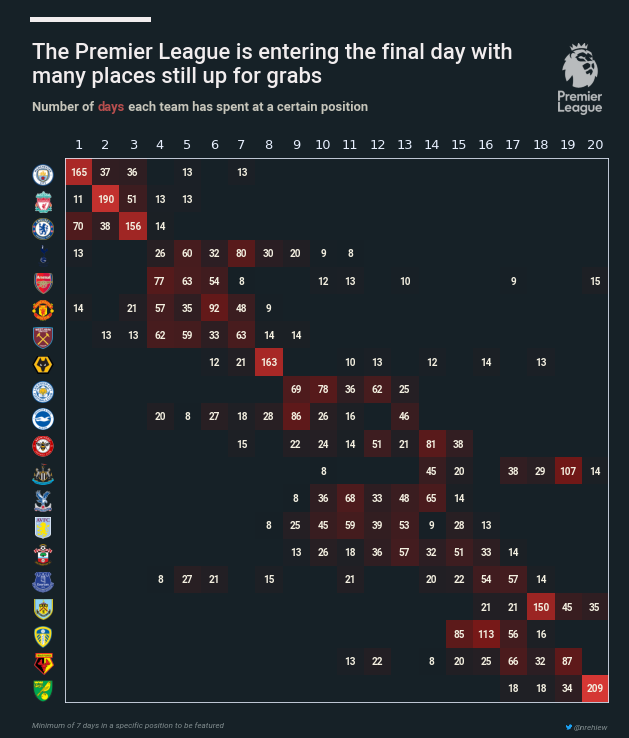

In [11]:
#tyles 
font = 'Roboto'
title_size = 22
title_color = '#F1EDEE'
subtitle_size = 13
subtitle_color = '#E05A58'
notes_size = 8
notes_color = '#A0ACAD'
bg_color = '#162127'
cmap_lst = [bg_color,'#721817','#D53734']
text_color = '#F3EFE0'
axis_color = '#E8F0FF'

#figure
cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax = plot_heatmap(ax,vals,font,cmap,text_color,axis_color)
fig.patch.set_facecolor(bg_color)

#padding 
fig.text(0.055,1.08,' ')
fig.text(0.905,1.08,' ')
#top graphics
fig.text(0.09,1.01,'The Premier League is entering the final day with\nmany places still up for grabs',va='center',ha='left',color=title_color,font=font,fontsize=title_size,fontweight='medium')
fig_text(0.09,0.952,'Number of <days> each team has spent at a certain position',highlight_textprops=[{'color':subtitle_color}],va='center',ha='left',color=text_color,font=font,fontsize=subtitle_size,alpha=0.8,fontweight='demibold')
_ = fig.add_artist(lines.Line2D([0.09,0.25],[1.073],linewidth=5,color=title_color))
logoax = fig.add_axes([0.8,0.94,0.1,0.1])
img= Image.open(r"Premier League.png").convert('LA')
pixels = img.load()
for i in range(img.size[0]): # for every pixel:
    for j in range(img.size[1]):
        if pixels[i,j][1] != 0:
            tmp = list(pixels[i,j])
            tmp[0] = 255
            pixels[i,j] = tuple(tmp) # change to white
_ = logoax.imshow(img,alpha=0.7)
logoax.axis('off')

#notes 
fig.text(0.09,0.09,'Minimum of 7 days in a specific position to be featured',font=font,fontsize =notes_size,color = notes_color,alpha=0.8,style ='italic')
ax = fig.add_axes([0.83,0.085,0.01,0.01])
im = plt.imread(r"Assets\icon.png")
ax.imshow(im)
ax.axis('off')
_ = fig.text(0.89,0.09,'@nrehiew',ha='right',va='center',font=font,fontsize =notes_size,color = notes_color,alpha=0.8,style ='italic')
plt.savefig('Completed/epltable.jpg',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)